Advanced Lane Finding Project

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle
%matplotlib inline

Reading in and Visualizing the Test Images

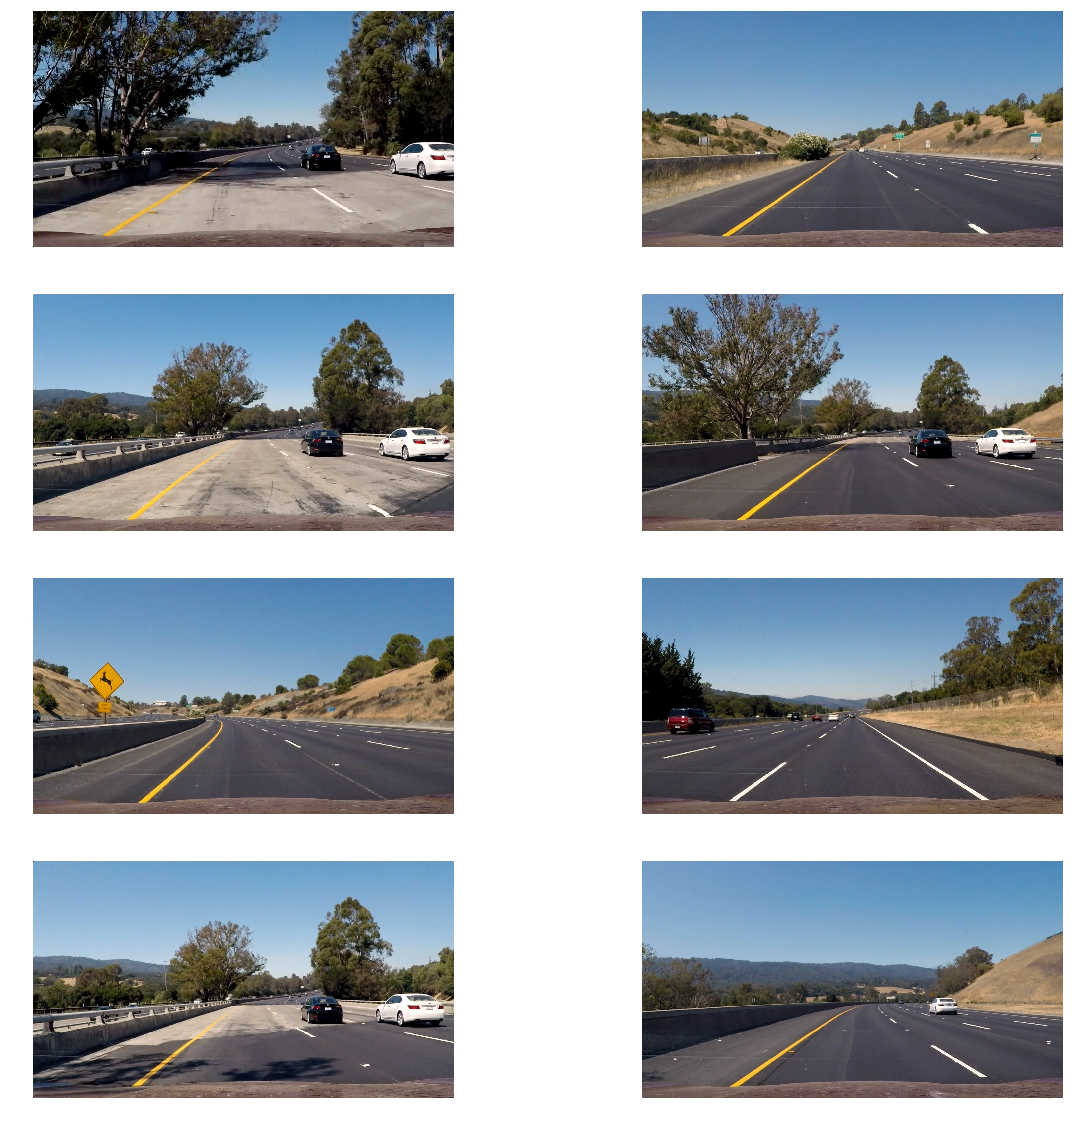

In [2]:
#Reading in all the image names

images=os.listdir("test_images/")

#Plotting/Visualizing
plt.figure(figsize=(20,20))
#Plotting the images
counter=1
image_input=[]
for image in images:
    image_input.append(mpimg.imread('./test_images/' + image))
    plt.subplot(4,2,counter)
    plt.imshow(image_input[counter-1])
    plt.axis('off')
    counter=counter+1
plt.show()  


Checking the attributes of Test Images 

In [3]:
#Size of Test Images

image_input= np.asarray(image_input)
print("Shape of Test Images",image_input[0].shape)

#Total Number of Images

print("Number of Test Images",len(image_input))

Shape of Test Images (720, 1280, 3)
Number of Test Images 8


Camera Calibration and Distortion Correction

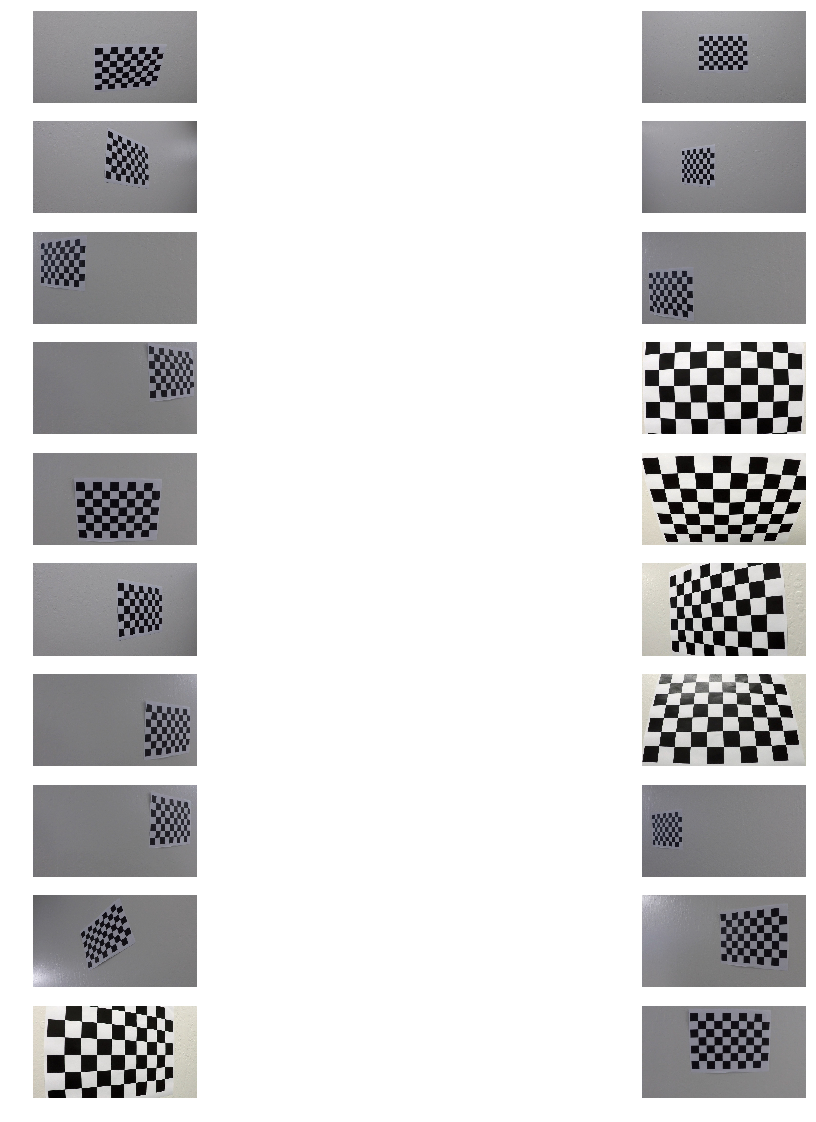

In [4]:
#Read in Calibration Images

cal=os.listdir("camera_cal/")
image_input_cal=[]                                                                      
plt.figure(figsize=(20,20))
#Plotting the images
counter=1
for image in cal:
    image_input_cal.append(mpimg.imread('./camera_cal/' + image))
    plt.subplot(10,2,counter)
    plt.imshow(image_input_cal[counter-1])
    plt.axis('off')
    counter=counter+1
plt.show()  



Trying the Camera Calibration technique given in classroom in carnd-camera-calibration repo

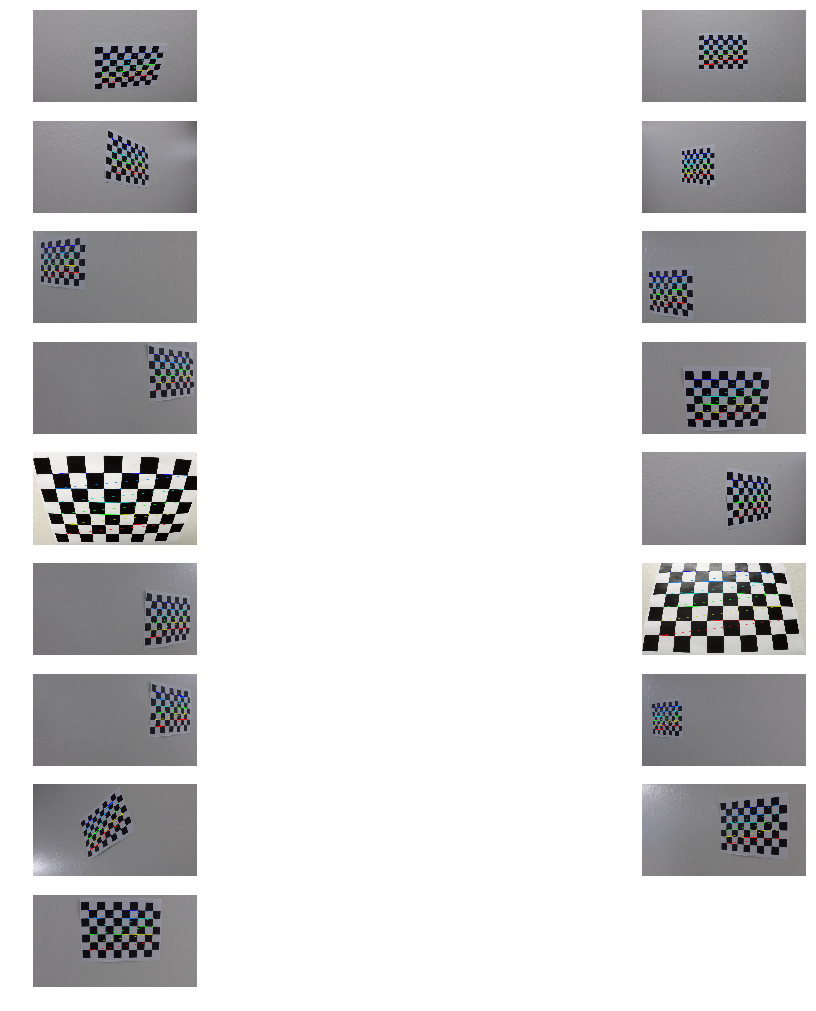

In [5]:
#Prepare Object and Image Points

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

imagecal_copy=[]
for image in image_input_cal:
    imagecal_copy.append(image)
plt.figure(figsize=(20,20))
counter=1
# Step through the list of calibtration Images and search for chessboard corners
for image in imagecal_copy:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image, (8,6), corners, ret)
        plt.subplot(10,2,counter)
        plt.imshow(image)
        plt.axis('off')
        counter=counter+1
        #cv2.imshow('img', image)

Calibrating Camera, Finding distortion coefficients, and Visualizing result

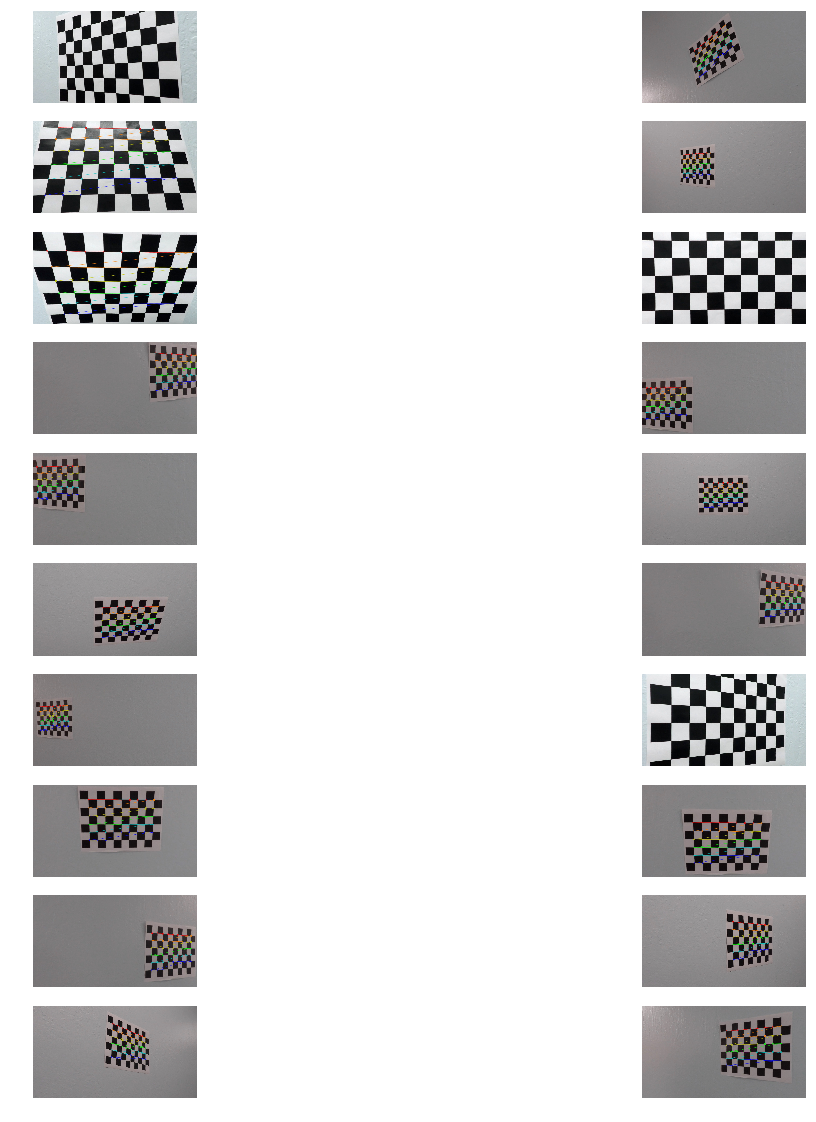

In [6]:

%matplotlib inline

# Test undistortion on the images

# Do camera calibration given object points and image points
image_cal=mpimg.imread('./camera_cal/calibration1.jpg')

size = (image_cal.shape[1], image_cal.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size,None,None)

counter=0
for image in image_input_cal:
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    name="./calibration_output/"+"output_"+cal[counter];
    cv2.imwrite(name,dst)
    counter=counter+1

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./calibration_pickle/wide_dist_pickle.p", "wb" ) )

#Read in Undistortion Image output and Visualize it
import glob

undis=glob.glob("calibration_output/output*.jpg")
                                                                     
plt.figure(figsize=(20,20))
#Plotting the images
counter=1
for und in undis:
    plt.subplot(10,2,counter)
    plt.imshow(mpimg.imread(und))
    plt.axis('off')
    counter=counter+1
plt.show()  

Defining functions for gradient thresholds

In [20]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [21]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [22]:
#Sobel Gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #Grayscaling
    #gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #AbsoluteDerivative
    if orient=='x':
        abs_sobel=np.absolute(cv2.Sobel(img,cv2.CV_64F,1,0))
    elif orient=='y':
        abs_sobel=np.absolute(cv2.Sobel(img,cv2.CV_64F,0,1))
    #Scaling
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    #Mask
    sxbinary=np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    #ReturnMask
    grad_binary = np.copy(sxbinary) 
    return grad_binary


In [30]:
#Magnitude Gradient
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    #Grayscaling
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

In [24]:
#Direction of Gradient
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    #Grayscaling
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the gradient direction
    gradmag = np.arctan2(sobely, sobelx)
    # Rescale to 8 bit
    #scale_factor = np.max(gradmag)/255 
    #gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    dir_binary = np.zeros_like(gradmag)
    dir_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return dir_binary

In [25]:
#Combine Gradients

def combine(dir_binary,gradx,grady,mag_binary):
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 0))] = 1
    return combined

In [26]:
#Color Thresholding

def color_threshold(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    
    # Threshold color channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    yellow_min = 39
    yellow_max = 69
    h_binary_yellow = np.zeros_like(h_channel)
    h_binary_yellow[(h_channel >= yellow_min) & (h_channel <= yellow_max)] = 1
    
    light_min=95
    light_max=100
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= light_min) & (l_channel <= light_max)] = 1
    cobinary = np.zeros_like(h_binary_yellow)
    cobinary[(h_binary_yellow == 1) & (l_binary == 1)] = 1
    #R Channel
    
    R = img[:,:,0]
    thresh = (150, 255)
    r_binary = np.zeros_like(R)
    r_binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    #Combining
    combined = np.zeros_like(s_binary)
    combined[((cobinary == 1) | (s_binary == 1)) & ((cobinary == 1) | (r_binary == 1))] = 1
    return combined
    

In [27]:
#Color and gradient

def combine_color_grad(color_binary,grad_binary):
    combined = np.zeros_like(color_binary)
    combined[(color_binary == 1) | (grad_binary == 1)] = 1
    return combined

In [28]:
#Applying Perspective Transform

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./calibration_pickle/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
undist_images=[]

def corners_unwarp(img, mtx, dist):
    # Step 1 - Remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_images.append(undist)
    # Step 2 - Covert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Step 3 - Extract the shape
    img_size = gray.shape[:2]

    # Step 4 - Define source and destination points for transform
    #src = np.float32([[(img_size[1] / 2) - 55, img_size[0] / 2 + 100], [((img_size[1] / 6) - 10), img_size[0]], [(img_size[1] * 5 / 6) + 60, img_size[0]],[(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    #dst = np.float32([[(img_size[1] / 4), 0], [(img_size[1] / 4), img_size[0]], [(img_size[1] * 3 / 4), img_size[0]], [(img_size[1] * 3 / 4), 0]])
    
    src=np.float32([(570,470),(720,470),(980,680),(320,680)])
    dst=np.float32([(320,0),(980,0),(980,720),(320,720)])
    
    # Step 5 - Calculate M and Minv
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Step 6 - Warp the image into a bird's eye view
    warped = cv2.warpPerspective(img, M, (img_size[1],img_size[0]))
    return warped, M, Minv


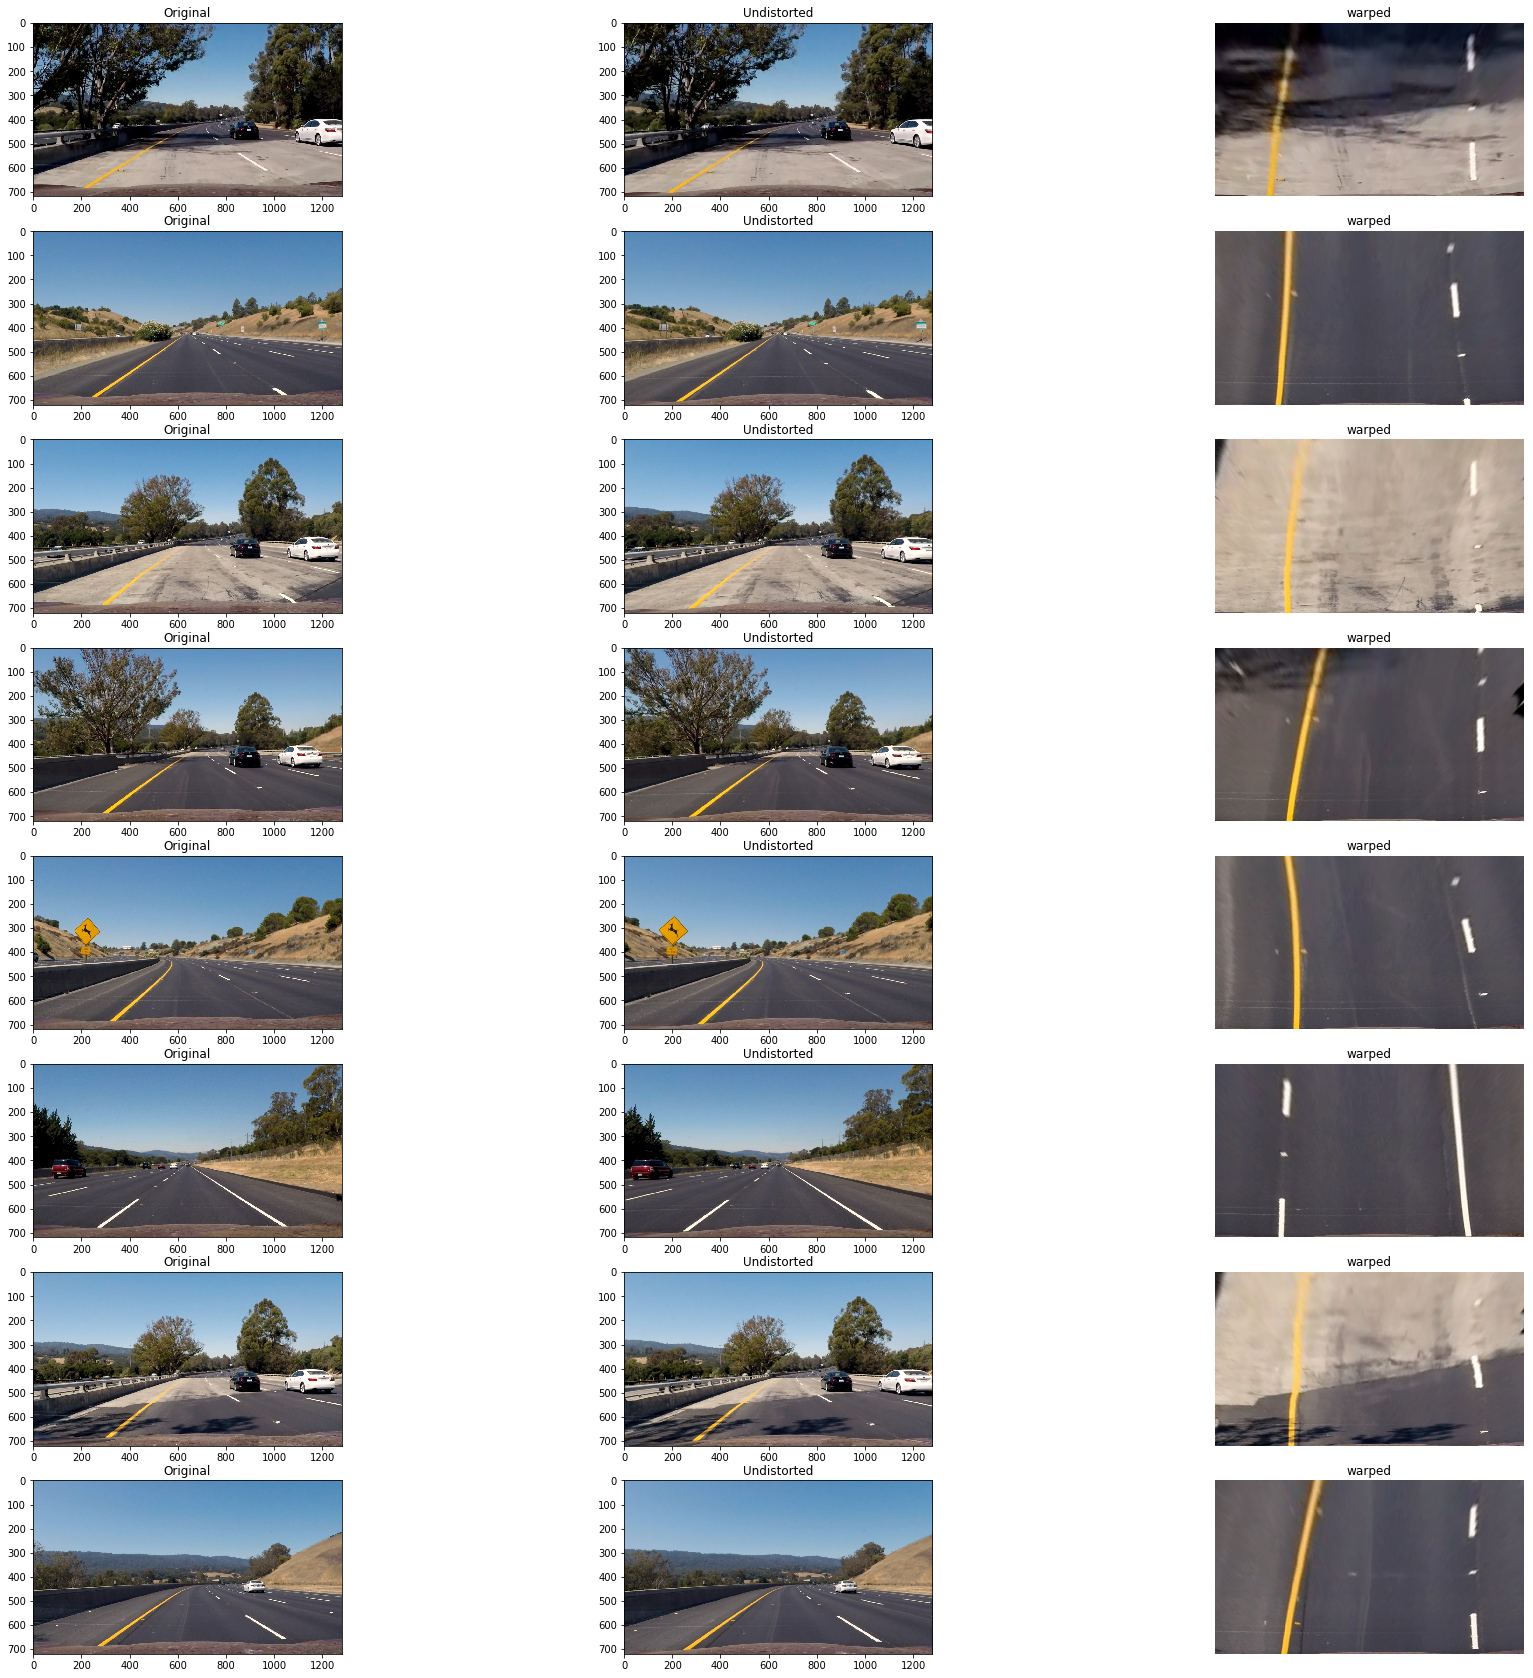

In [16]:
#Testing on images

warped_list=[]
perspective_list=[]
Minv_list=[]

counter1=1
counter2=0
plt.figure(figsize=(30,30))
for image in image_input:
    top_down, perspective_M, Minv = corners_unwarp(image,mtx, dist)
    warped_list.append(top_down)
    perspective_list.append(perspective_M)
    Minv_list.append(Minv)
    plt.subplot(8,3,counter1)
    plt.imshow(image)
    plt.title("Original")
    plt.subplot(8,3,counter1+1)
    plt.imshow(undist_images[counter2])
    plt.title("Undistorted")
    plt.subplot(8,3,counter1+2)
    plt.imshow(top_down)
    plt.title("warped")
    plt.axis('off')
    counter1=counter1+3
    counter2=counter2+1
plt.show()  


In [17]:
#Applying Image Processing
def image_process(image):
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = canny(gray,60,240)
    # Applying Gaussian smoothing / blurring
    blur_gray = gaussian_blur(edges,9)
    # Apply each of the thresholding functions
    #gradx = abs_sobel_thresh(blur_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    #grady = abs_sobel_thresh(blur_gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(blur_gray, sobel_kernel=5, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(blur_gray, sobel_kernel=15, thresh=(0.7, 1.3))
    #grad_binary=combine(dir_binary,gradx,grady,mag_binary)
    color_binary=color_threshold(image)
    combined=combine_color_grad(color_binary,mag_binary)
    return combine_color_grad(color_binary,mag_binary)

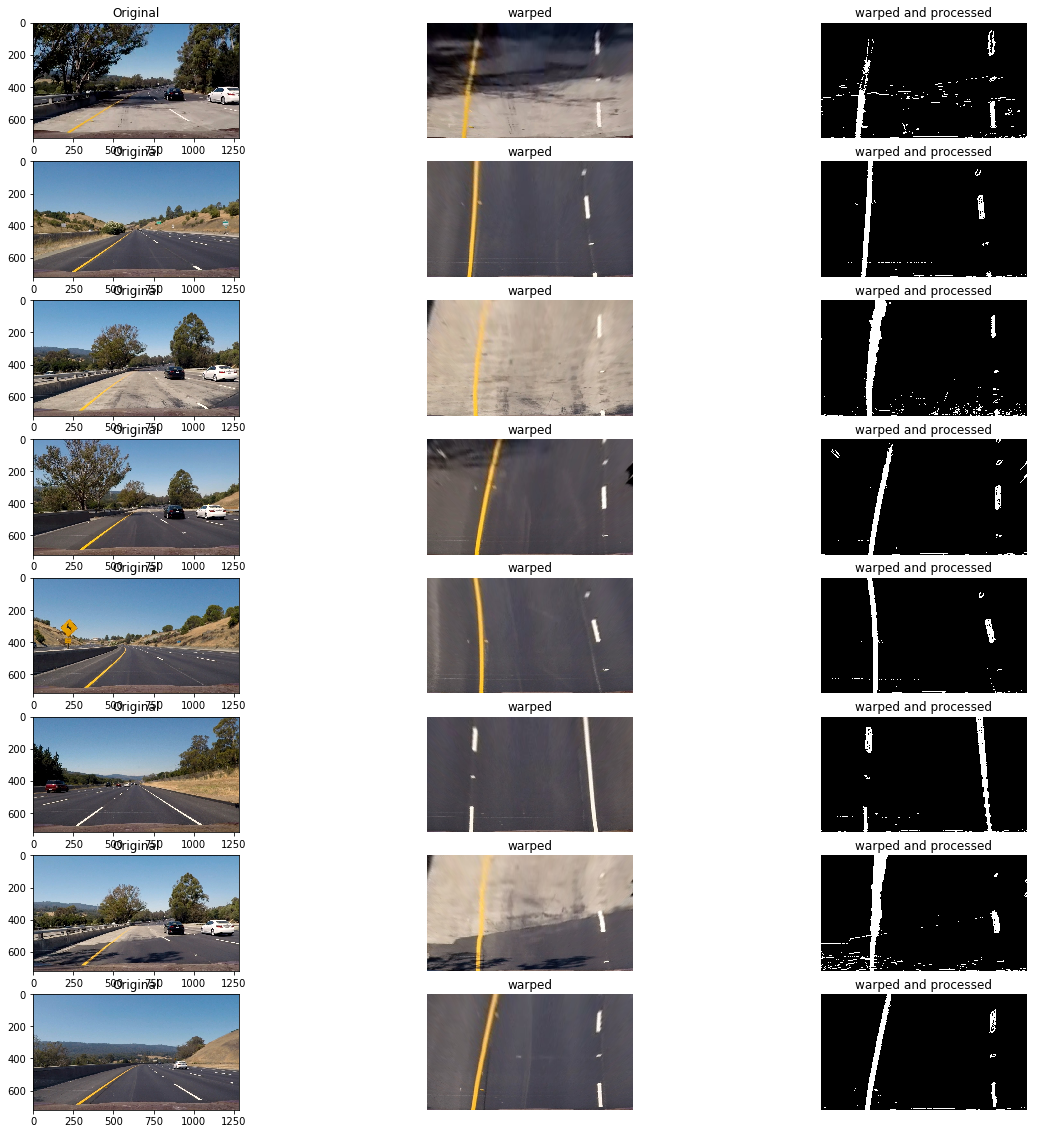

In [18]:
#Applying Image Processing

warped_processed=[]
counter1=1
counter2=0
#ksize=3
plt.figure(figsize=(20,20))
for image in warped_list:
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = canny(gray,60,240)
    # Applying Gaussian smoothing / blurring
    blur_gray = gaussian_blur(edges,9)
    # Apply each of the thresholding functions
    #gradx = abs_sobel_thresh(blur_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    #grady = abs_sobel_thresh(blur_gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(blur_gray, sobel_kernel=5, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(blur_gray, sobel_kernel=15, thresh=(0.7, 1.3))
    #grad_binary=combine(dir_binary,gradx,grady,mag_binary)
    color_binary=color_threshold(image)
    combined=combine_color_grad(color_binary,mag_binary)
    plt.subplot(8,3,counter1)
    plt.imshow(image_input[counter2])
    plt.title("Original")
    plt.subplot(8,3,counter1+1)
    plt.imshow(image, cmap='gray')
    plt.title("warped")
    plt.axis('off')
    plt.subplot(8,3,counter1+2)
    plt.imshow(combined, cmap='gray')
    plt.title("warped and processed")
    plt.axis('off')
    counter1=counter1+3
    counter2=counter2+1
    warped_processed.append(combined)
plt.show()  

1274.26775138 m 699.664704282 m
3413.36618389 m 3114.83692029 m
906.113197874 m 3241.71420737 m
2287.00099718 m 2457.8997475 m
1237.15390119 m 522.019158985 m
8050.53691006 m 55560.2299298 m
166245.37931 m 1118.32522888 m
3232.40878972 m 1451.70091592 m


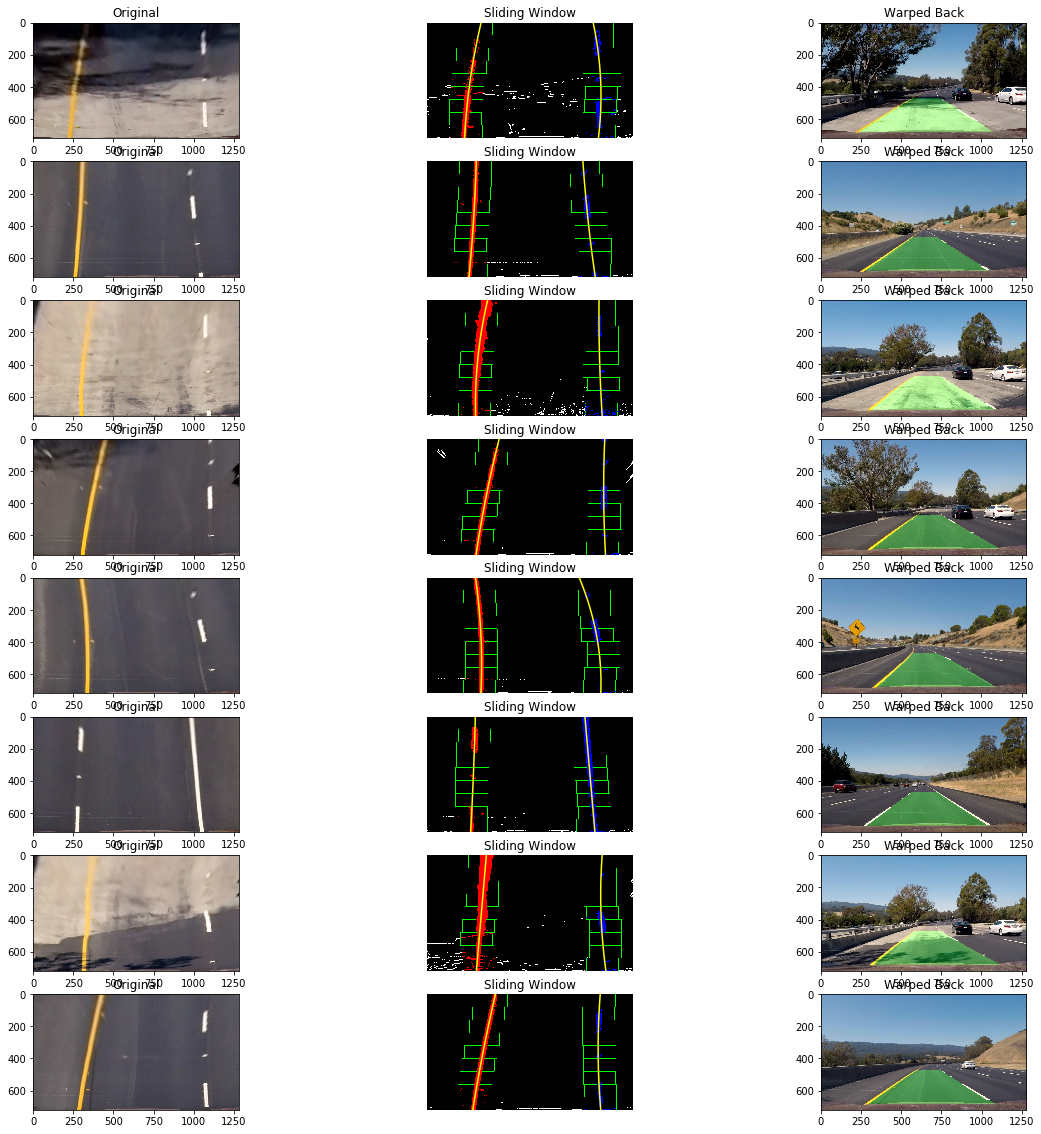

In [19]:
#Sliding Window Polyfit - Using the implementation provided in the classroom Lesson 33

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
warp_back=[]
lanes=[]
counter1=1
counter2=0
plt.figure(figsize=(20,20))
for image in warped_processed:
    image=np.asarray(image)
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #Visualization
    #At this point, you're done! But here is how you can visualize the result as well:

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_list[counter2], (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image_input[counter2], 1, newwarp, 0.3, 0)
    warp_back.append(result)
    
    
    lanes.append(out_img)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.subplot(8,3,counter1)
    plt.imshow(warped_list[counter2])
    plt.title("Original")
    plt.subplot(8,3,counter1+1)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.title("Sliding Window")
    plt.axis('off')
    plt.subplot(8,3,counter1+2)
    plt.imshow(warp_back[counter2])
    plt.title("Warped Back")
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    counter1=counter1+3
    counter2=counter2+1
plt.show()

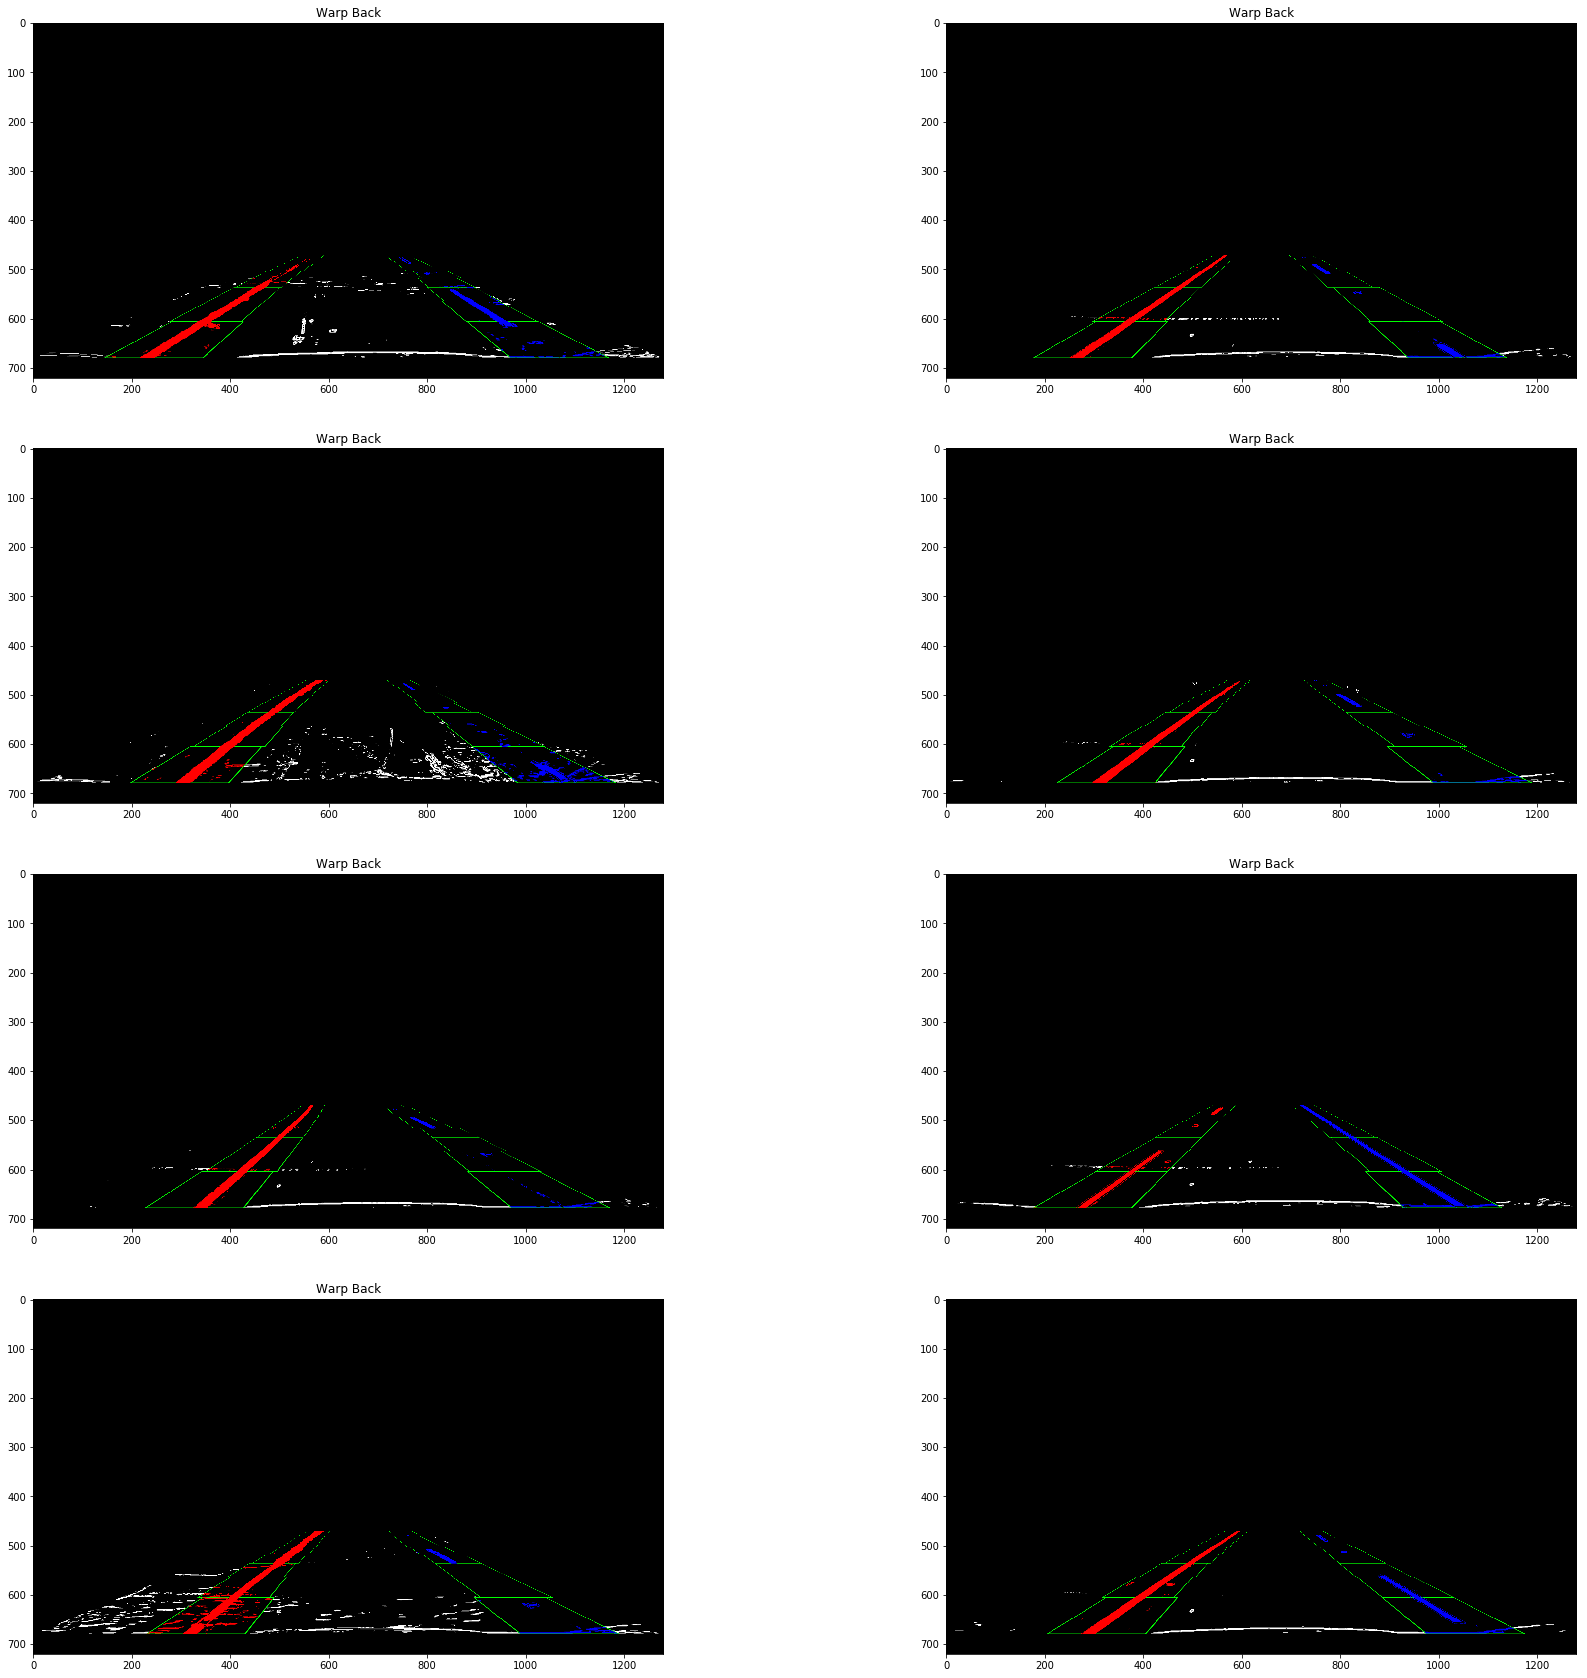

In [20]:
#lane Boundaries warped visualization
warp_back=[]
plt.figure(figsize=(30,30))
counter1=1
for image in lanes:
    image_size = image.shape[:2]
    warp_back.append(cv2.warpPerspective(image, Minv_list[counter1-1], (image_size[1],image_size[0])))
    plt.title("Warp Back")
    plt.subplot(4,2,counter1)
    plt.imshow(warp_back[counter1-1])
    counter1=counter1+1
plt.show()

In [29]:
#Now creating a pipeline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./calibration_pickle/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
font = cv2.FONT_HERSHEY_SIMPLEX

def pipeline(img):
    top_down, perspective_M, Minv = corners_unwarp(img,mtx, dist)
    gray=cv2.cvtColor(top_down, cv2.COLOR_RGB2GRAY)
    edges = canny(gray,60,240)
    # Applying Gaussian smoothing / blurring
    blur_gray = gaussian_blur(edges,9)
    # Apply the thresholding functions
    mag_binary = mag_thresh(blur_gray, sobel_kernel=5, mag_thresh=(30, 100))
    color_binary=color_threshold(top_down)
    combined=combine_color_grad(color_binary,mag_binary)
    
    image=np.asarray(combined)
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #Visualization
    #At this point, you're done! But here is how you can visualize the result as well:

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #Calculate the position of vehicle
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    text_left=str(left_curverad)+'m'
    cv2.putText(result, text_left, (100, 100), font, 0.5, (0, 0, 0), 2, cv2.LINE_AA)
    text_left='Position'+str(np.absolute((img.shape[1]//2)- (np.min(pts_left)+np.max(pts_right)))* xm_per_pix)+'m'
    cv2.putText(result, text_left, (500, 100), font, 0.5, (0, 0, 0), 2, cv2.LINE_AA)
    return result
    

In [31]:
#Testing on Video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = './test_videos_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video_output.mp4
[MoviePy] Writing video ./test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:20<00:00,  6.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video_output.mp4 

CPU times: user 7min 3s, sys: 11.8 s, total: 7min 15s
Wall time: 3min 21s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [35]:
video_output_2 = './test_videos_output/challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("./challenge_video.mp4")
challenge_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(video_output_2, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/challenge_video_output.mp4
[MoviePy] Writing video ./test_videos_output/challenge_video_output.mp4


100%|██████████| 485/485 [01:13<00:00,  6.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/challenge_video_output.mp4 

CPU times: user 2min 41s, sys: 1.75 s, total: 2min 43s
Wall time: 1min 14s


In [36]:
video_output_3 = './test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("./harder_challenge_video.mp4")
harder_challenge_clip = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(video_output_3, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video ./test_videos_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:25<00:00,  5.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/harder_challenge_video.mp4 

CPU times: user 7min 8s, sys: 3.54 s, total: 7min 12s
Wall time: 3min 26s
